# Text Classification Problem
Classification of 4 types of texts (Sports, World, Business, Science/Technology)

# Data Preparation
The [training data](https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset?select=train.csv) contains 120000 samples of news articles.
The algorithm will be trained to predict the labels for test texts:
- 1 - World
- 2 - Sports
- 3 - Business
- 4 - Science/Technology


In [1]:
classes = ["World", "Sports", "Business", "Science/Technology"]

Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading Libraries

In [3]:
# Basic
import string
import nltk
import numpy as np
import pandas as pd

# Visuals
import seaborn as sns
import matplotlib.pyplot as plt

# Scickit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Tensorflow
import tensorflow as tf

# Loading in Dataframe

In [4]:
df = pd.read_csv('./drive/MyDrive/text-classification/train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Class Index  120000 non-null  int64 
 1   Title        120000 non-null  object
 2   Description  120000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB


Merge title and description in one column and give label

In [5]:
df['label'] = df['Class Index'].apply(lambda idx: classes[idx - 1])
df['text'] = df['Title'].astype(str) + ". " + df['Description']
df.drop(['Class Index', 'Title', 'Description'], axis=1, inplace=True)

# Data Exploration

In [6]:
pd.set_option('display.max_colwidth', None)
df.sample(10)

,label,text
105306,Business,Hurricane Season Comes to an End. Nov. 30 - In under 24-hours one of the nation #39;s worst hurricane seasons will come to an end. The end of Tuesday day marks the end of the 2004 hurricane season.
14657,Science/Technology,"A renaissance for the workstation?. Santa Clara, Calif.-based Orion Multisystems has come up with a new type of workstation that can hold several processors clustered together for greater power."
62507,Business,"AT T, MCI May Be Cheap, But No One Buying (Reuters). Reuters - Shares of long-distance phone\companies AT T Corp. and MCI Inc. have plunged\about 20 percent this year, but potential buyers seem to be\holding out for clearance sales."
99296,Science/Technology,IBM Exec May Become Computer Associates CEO (AP). AP - Troubled business software company Computer Associates International Inc. reportedly has selected longtime IBM executive John Swainson as its new chief executive.
116147,Sports,"Good News (Wells), Bad News (Schilling). The left-hander David Wells passed a physical and was introduced at a Fenway Park news conference, and the timing could not have been more striking."
11241,World,"Al-Sadr accepts cleric #39;s plan to end Najaf uprising, aide says. NAJAF, IRAQ - Militant leader Muqtada al-Sadr agreed on Thursday to a peace plan presented by Iraq #39;s most revered Shia cleric, who rode into Najaf hours earlier to try to end the bloody three-week uprising."
30623,World,"US Says Kills 60 Foreign Fighters in Iraq Strike. US forces launched fresh attacks in and near the restive Iraqi city of Falluja overnight, killing about 60 foreign fighters, the US military said on Friday."
72954,Business,"Chain Store Sales Fell in Oct 23 Week. NEW YORK (Reuters) - U.S. chain store sales fell in the third week of October, with sales being delayed by the summer like weather, a report said on Tuesday."
45024,World,"Israel Plans Large-Scale Gaza Operation (AP). AP - Israel's defense minister decided Thursday to launch a large-scale military operation in the Gaza Strip to stop Palestinian rocket fire on Israeli border towns, an Israeli radio station reported."
19056,Science/Technology,"iMac G5: A new option. Last week, Mac loyalists had gathered for an announcement they have been waiting for months to hear. Sitting at the Paris Apple Expo or crouched in front of a computer screen in a Mac chat room, thousands"


# Text Preprocessor

Create Text Preprocessor

In [7]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

class TextPreprocessor:
    def __init__(self, language="english", use_lemmatization=True, use_stemming=False):
        self.language = language
        self.use_stemming = use_stemming
        self.use_lemmatization = use_lemmatization
        self.__setup_default_language()

    @staticmethod
    def __tokenize_text(text):
        words = nltk.tokenize.word_tokenize(text.lower())
        return list(filter(lambda word: word not in string.punctuation, words))

    def __setup_default_language(self):
        self.stop_words = set(nltk.corpus.stopwords.words(self.language))
        if self.use_stemming:
            self.stemmer = nltk.stem.PorterStemmer()
            self.stem = self.stemmer.stem
        if self.use_lemmatization:
            self.lemmatizer = nltk.stem.WordNetLemmatizer()
            self.lemmatize = self.lemmatizer.lemmatize
            self.stemmer = nltk.stem.PorterStemmer()

    def __remove_stopwords(self, words):
        return list(filter(lambda word: word not in self.stop_words, words))

    def __stem_words(self, words):
        return map(self.stem, words)

    def __lemmatize_words(self, words):
        return map(self.lemmatize, words)

    def preprocess(self, text):
        """Preprocess the input text.

        Tokenizes the text, removes stopwords, and optionally performs lemmatization and/or stemming.

        Args:
            text (str): The input text to be preprocessed.

        Returns:
            str: The preprocessed text.
        """
        tokens = self.__tokenize_text(text)
        tokens = self.__remove_stopwords(tokens)
        if self.use_lemmatization:
            tokens = self.__lemmatize_words(tokens)
        if self.use_stemming:
            tokens = self.__stem_words(tokens)
        return ' '.join(tokens)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Apply Text Preprocessor to dataframe

In [8]:
text_preprocessor = TextPreprocessor()
df['text'] = df['text'].apply(lambda txt: text_preprocessor.preprocess(txt))
df.sample(5)

,label,text
74810,World,survivor recognises accused best bakery case reuters reuters survivor massacre hindu-muslim riot gujarat 2002 told court wednesday recognised seven men night attack accused killing 14 people hacking burning death
16344,Business,singapore economy may grow 8 despite high oil price despite higher oil price singapore government wednesday keep economic growth forecast 8 percent 9 percent year growth 3 percent 5 percent next year
112577,World,watch list glance ap ap measure related transportation security besides expanded use government watch list flight cruise airport included intelligence overhaul legislation
27335,Science/Technology,linux get standard make move preserve interoperability free standard group fsg announced release specification aim help keep linux operating system fragmenting allow application developed one version linux work one another
4070,Sports,budapest race renault podium fernando alonso finished third hungarian grand prix behind two unbeatable ferraris


# Train Test Split

In [9]:
X_train, X_temp = train_test_split(df, test_size = 0.2, stratify = df['label'], random_state = 25)
X_test, X_val = train_test_split(X_temp, test_size = 0.5, stratify = X_temp['label'], random_state = 25)

X_train2, X_temp2 = train_test_split(df, test_size = 0.999, stratify = df['label'], random_state = 25)
X_test2, X_val2 = train_test_split(X_temp2, test_size = 0.001 / 0.999, stratify = X_temp2['label'], random_state = 25)

print(f'The shape of train data {X_train.shape}')
print(f'The shape of validation data {X_val.shape}')
print(f'The shape of test data {X_test.shape}')


print(f'The shape 2 of train data {X_train2.shape}')
print(f'The shape 2 of validation data {X_val2.shape}')
print(f'The shape 2 of test data {X_test2.shape}')

The shape of train data (96000, 2)
The shape of validation data (12000, 2)
The shape of test data (12000, 2)
The shape 2 of train data (120, 2)
The shape 2 of validation data (120, 2)
The shape 2 of test data (119760, 2)


Сreate a barplot to see the class distribution.

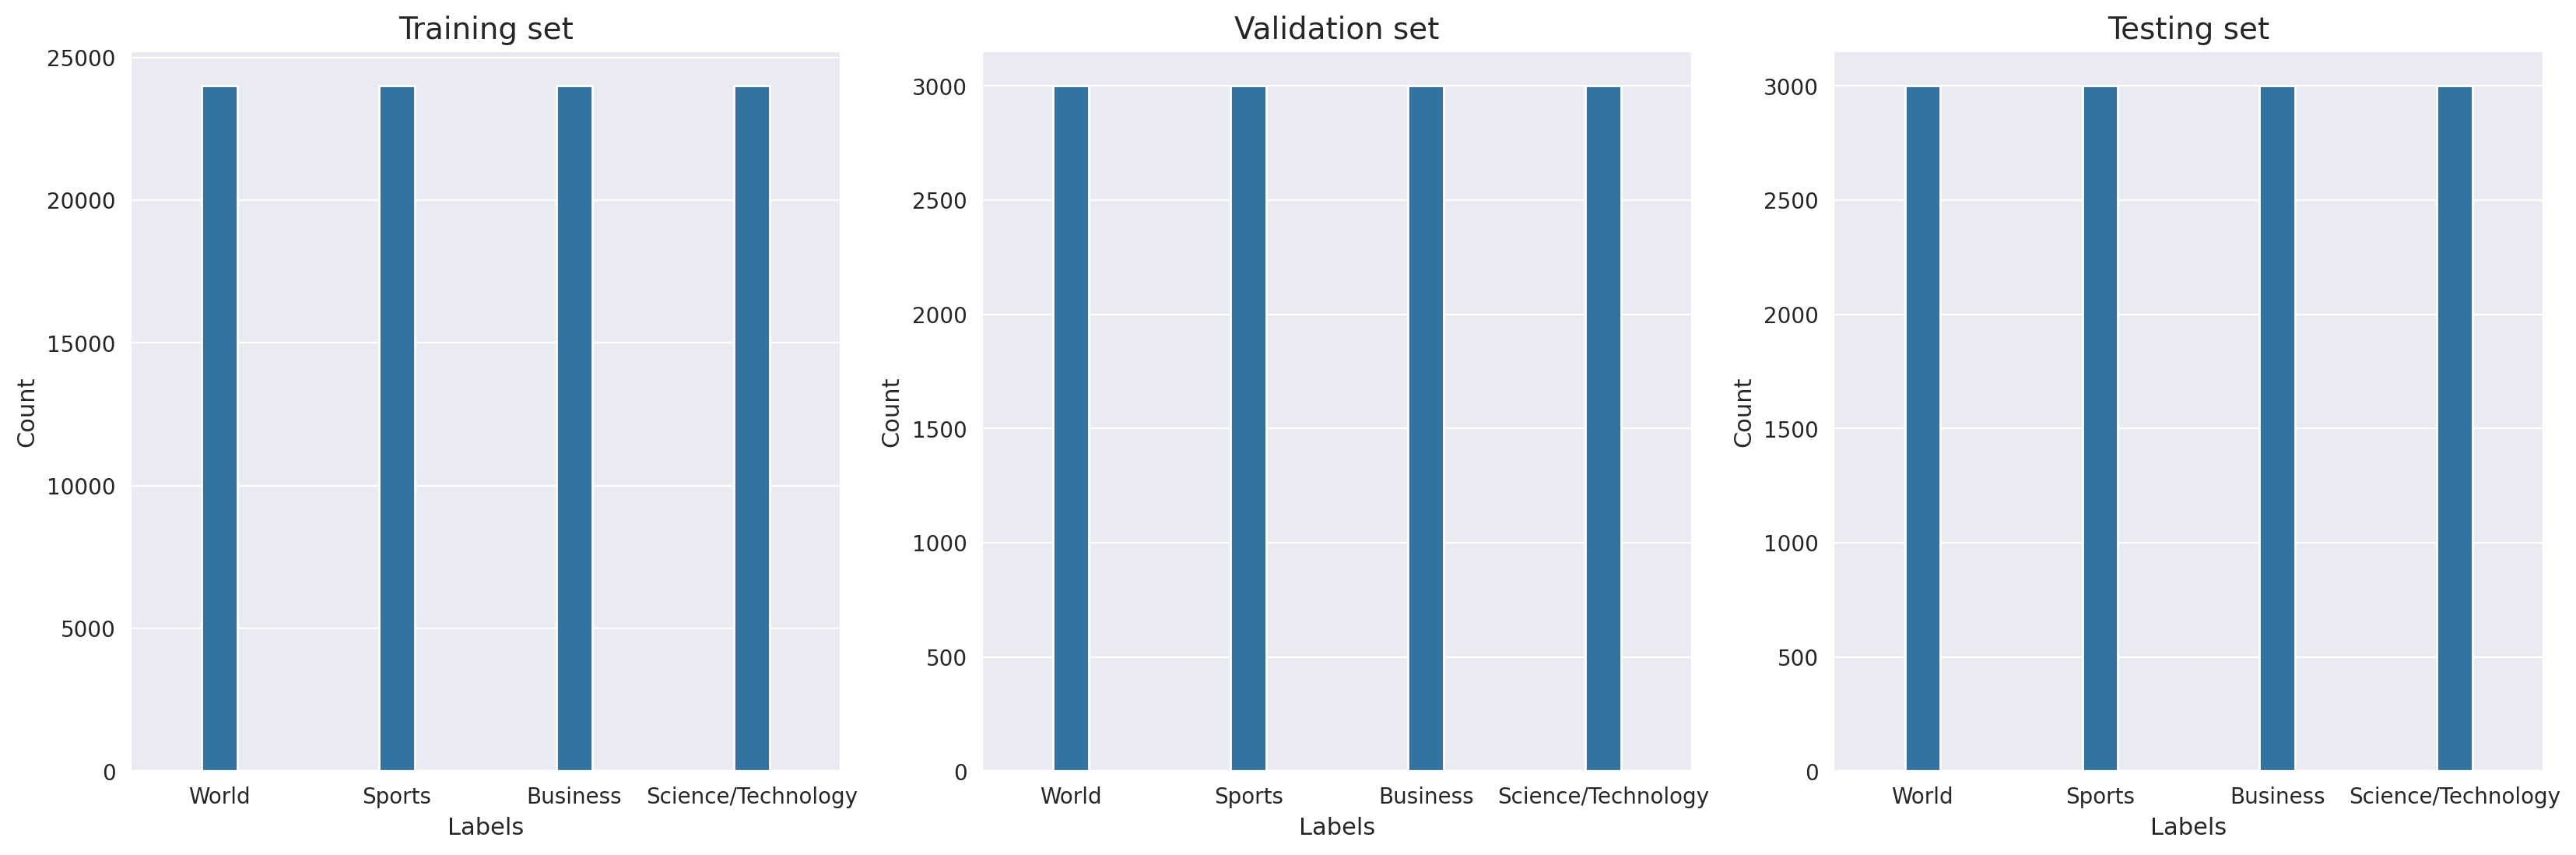

In [10]:
label1, count1 = np.unique(X_train.label,return_counts=True)
label2, count2 = np.unique(X_val.label,return_counts=True)
label3, count3 = np.unique(X_test.label,return_counts=True)

uni1 = pd.DataFrame(data=count1,index=classes,columns=['Count1'])
uni2 = pd.DataFrame(data=count2,index=classes,columns=['Count2'])
uni3 = pd.DataFrame(data=count3,index=classes,columns=['Count3'])

plt.figure(figsize=(20,6),dpi=200)
sns.set_style('darkgrid')

plt.subplot(131)
sns.barplot(data=uni1,x=uni1.index,y='Count1',width=0.2).set_title('Training set',fontsize=14)
plt.xlabel('Labels',fontsize=11)
plt.ylabel('Count',fontsize=11)

plt.subplot(132)
sns.barplot(data=uni2,x=uni2.index,y='Count2',width=0.2).set_title('Validation set',fontsize=14)
plt.xlabel('Labels',fontsize=11)
plt.ylabel('Count',fontsize=11)

plt.subplot(133)
sns.barplot(data=uni3,x=uni3.index,y='Count3',width=0.2).set_title('Testing set',fontsize=14)
plt.xlabel('Labels',fontsize=11)
plt.ylabel('Count',fontsize=11)

plt.show()

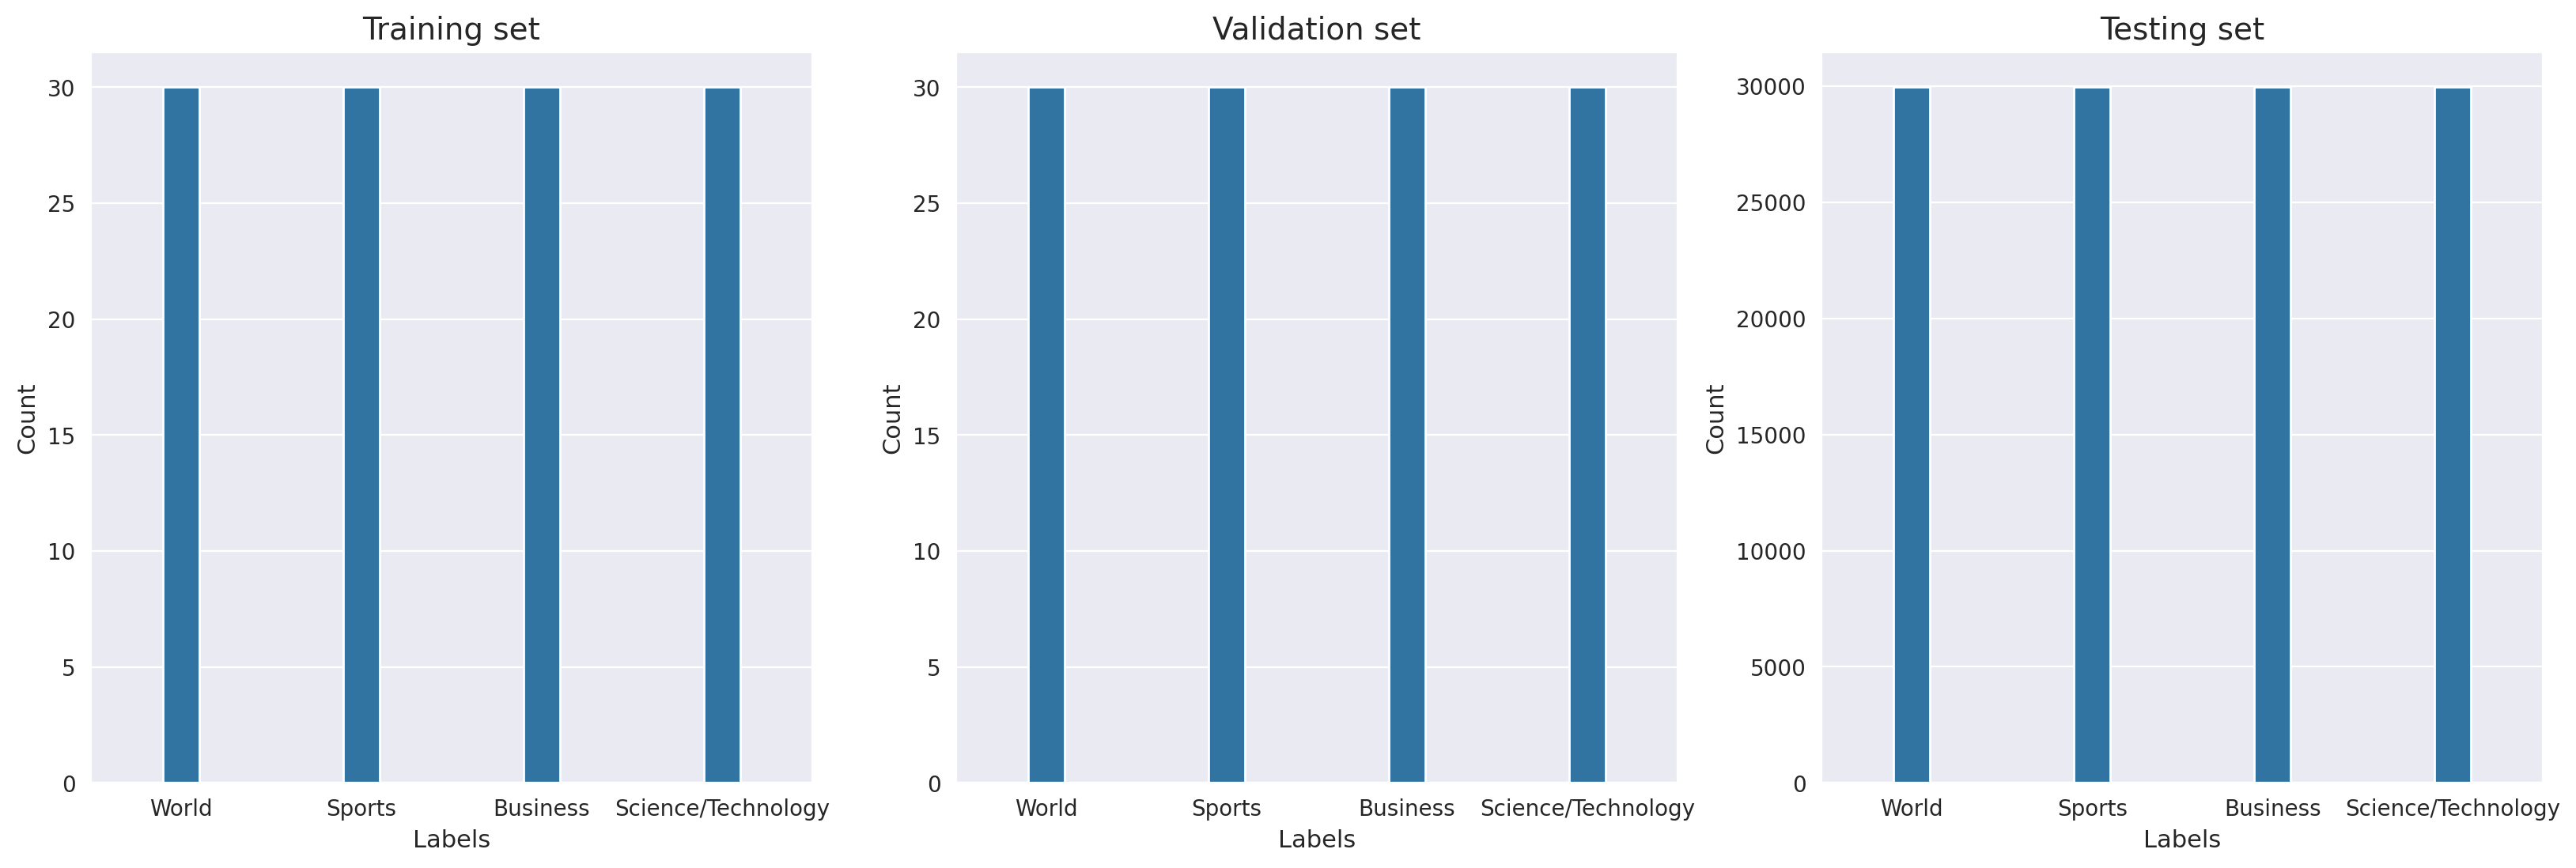

In [11]:
label1, count1 = np.unique(X_train2.label,return_counts=True)
label2, count2 = np.unique(X_val2.label,return_counts=True)
label3, count3 = np.unique(X_test2.label,return_counts=True)

uni1 = pd.DataFrame(data=count1,index=classes,columns=['Count1'])
uni2 = pd.DataFrame(data=count2,index=classes,columns=['Count2'])
uni3 = pd.DataFrame(data=count3,index=classes,columns=['Count3'])

plt.figure(figsize=(20,6),dpi=200)
sns.set_style('darkgrid')

plt.subplot(131)
sns.barplot(data=uni1,x=uni1.index,y='Count1',width=0.2).set_title('Training set',fontsize=14)
plt.xlabel('Labels',fontsize=11)
plt.ylabel('Count',fontsize=11)

plt.subplot(132)
sns.barplot(data=uni2,x=uni2.index,y='Count2',width=0.2).set_title('Validation set',fontsize=14)
plt.xlabel('Labels',fontsize=11)
plt.ylabel('Count',fontsize=11)

plt.subplot(133)
sns.barplot(data=uni3,x=uni3.index,y='Count3',width=0.2).set_title('Testing set',fontsize=14)
plt.xlabel('Labels',fontsize=11)
plt.ylabel('Count',fontsize=11)

plt.show()

# Model

Create dataset

In [12]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

categories = X_train['label'].astype('category').cat.categories.tolist()

train_ds = tf.data.Dataset.from_tensor_slices((X_train['text'].to_numpy(), X_train['label'].astype('category').cat.codes))
valid_ds = tf.data.Dataset.from_tensor_slices((X_val['text'].to_numpy(), X_val['label'].astype('category').cat.codes))
test_ds = tf.data.Dataset.from_tensor_slices((X_test['text'].to_numpy(), X_test['label'].astype('category').cat.codes))

train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
valid_ds = valid_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
valid_ds = valid_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

Create the text encoder

In [13]:
VOCAB_SIZE = 10000
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_ds.map(lambda text, label: text))
vocab = np.array(encoder.get_vocabulary())


Create model

In [24]:
EMBEDDING_DIM = 64
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(classes), activation="softmax")
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, None, 64)          640000    
                                                                 
 bidirectional_1 (Bidirecti  (None, None, 128)         66048     
 onal)                                                           
                                                                 
 global_max_pooling1d_1 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                      

# Callbacks

In [15]:
 early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                          patience=2,
                                                          min_delta=1e-3,
                                                          verbose=1,
                                                          restore_best_weights=True)

# Compile the Model
- Optimizer: Adam(default)
- Loss: Categorical Crossentropy
- Metrics: Accuracy

In [25]:
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.RMSprop(),
              metrics=['accuracy'])


# Fit the Model

We are now going to train our compiled model. The model will be trained for 5 epochs.

In [26]:
model_history = model.fit(train_ds,
                          validation_data=valid_ds,
                          callbacks=[early_stopping],
                          epochs=50)

Epoch 1/50
1500/1500 [==============================] - 195s 119ms/step - loss: 0.3290 - accuracy: 0.8912 - val_loss: 0.2671 - val_accuracy: 0.9094
Epoch 2/50
1500/1500 [==============================] - 179s 120ms/step - loss: 0.2346 - accuracy: 0.9225 - val_loss: 0.2777 - val_accuracy: 0.9028
Epoch 3/50
1500/1500 [==============================] - 179s 120ms/step - loss: 0.1985 - accuracy: 0.9343 - val_loss: 0.2443 - val_accuracy: 0.9182
Epoch 4/50
1500/1500 [==============================] - 182s 121ms/step - loss: 0.1713 - accuracy: 0.9451 - val_loss: 0.2498 - val_accuracy: 0.9203
Epoch 5/50
1500/1500 [==============================] - 179s 119ms/step - loss: 0.1447 - accuracy: 0.9536 - val_loss: 0.2951 - val_accuracy: 0.9154
Epoch 6/50
1500/1500 [==============================] - 177s 118ms/step - loss: 0.1192 - accuracy: 0.9617 - val_loss: 0.2953 - val_accuracy: 0.9130
Epoch 6: early stopping


Plot the result

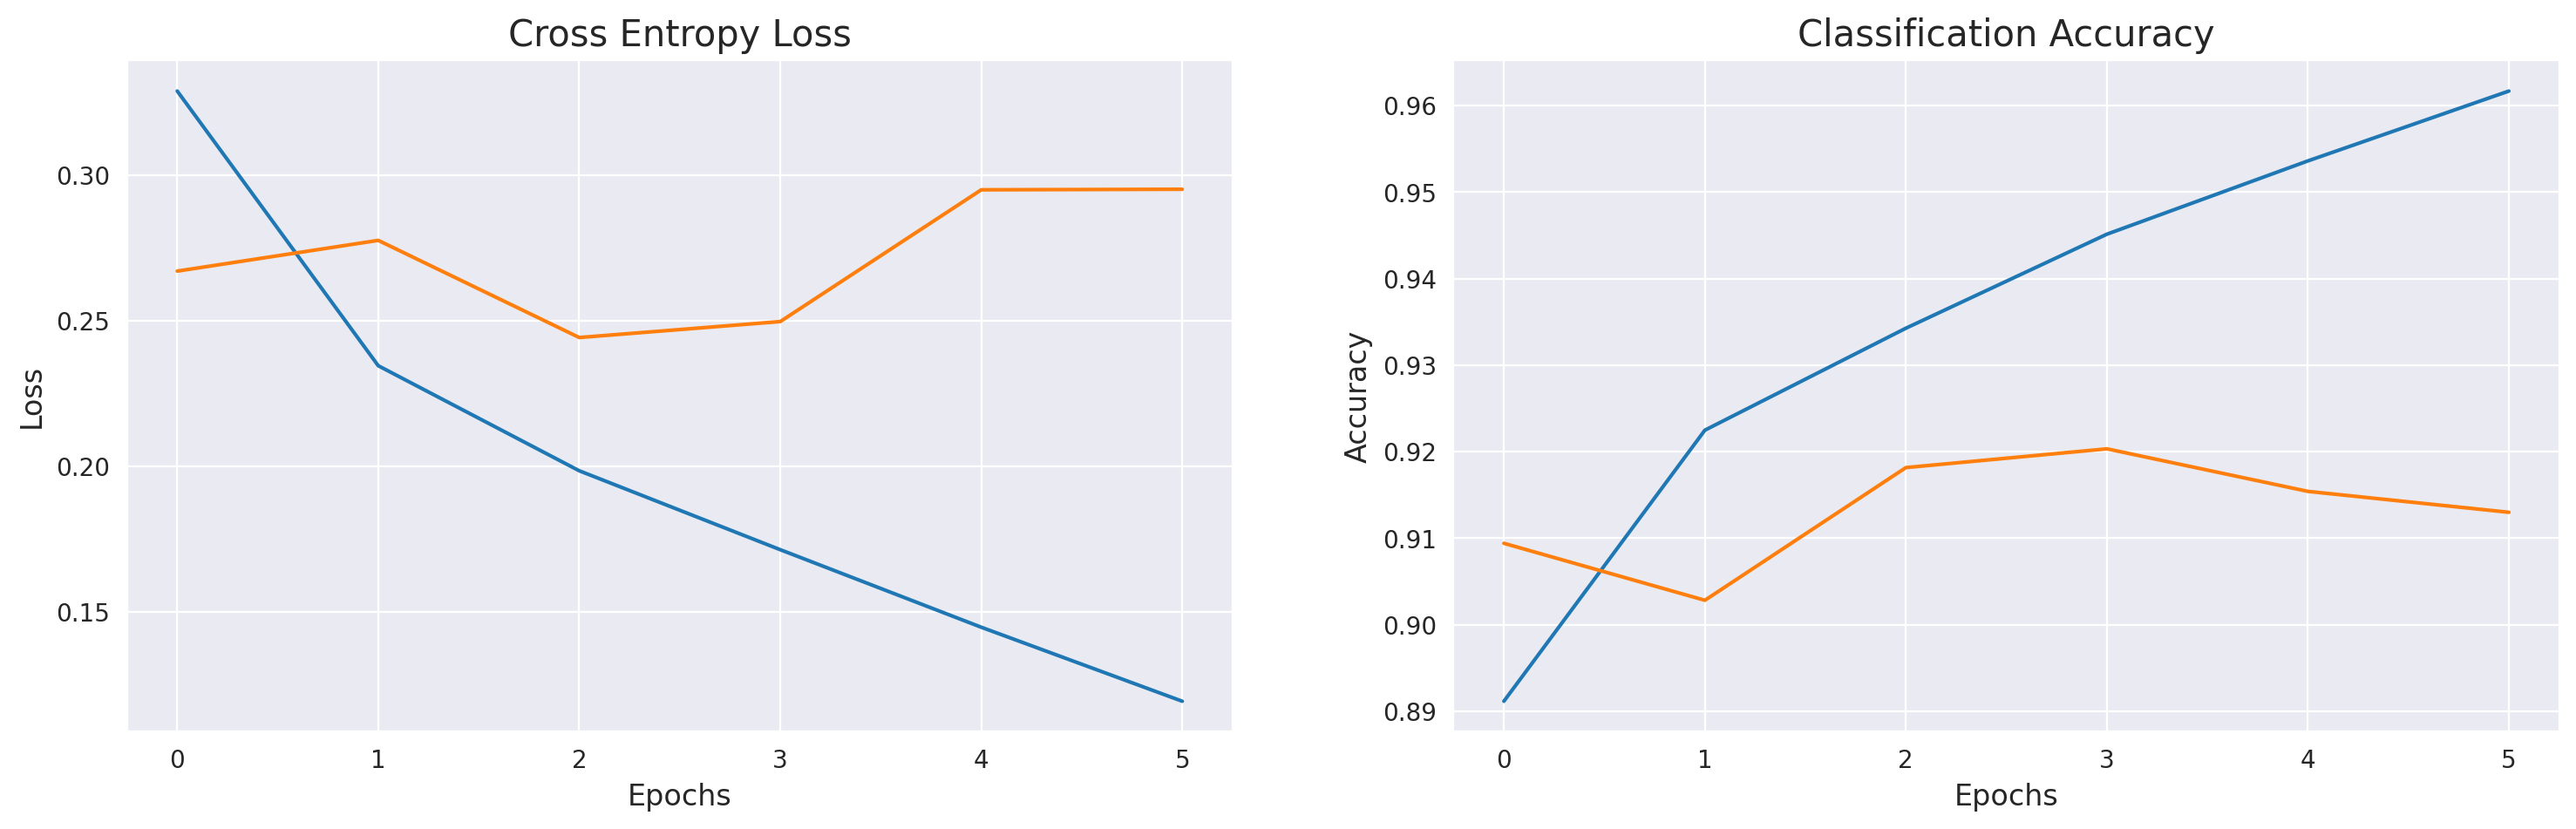

In [27]:
error = pd.DataFrame(model_history.history)

plt.figure(figsize=(18,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss', fontsize=15)

plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)

plt.plot(error['loss'])
plt.plot(error['val_loss'])

plt.subplot(122)
plt.title('Classification Accuracy', fontsize=15)

plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy',fontsize=12)

plt.plot(error ['accuracy'])
plt.plot(error['val_accuracy'])

plt.show()

# Evaluation

In [28]:
loss, acc = model.evaluate(train_ds)
print('The accuracy of the model for training data is: ', acc*100)
print('The loss of the model for training data is:', loss)

loss, acc = model.evaluate(valid_ds)
print('The accuracy of the model for validation data is:', acc*100)
print('The loss of the model for validation data is:', loss)

1500/1500 [==============================] - 53s 35ms/step - loss: 0.1151 - accuracy: 0.9628
The accuracy of the model for training data is:  96.28229141235352
The loss of the model for training data is: 0.11512074619531631
188/188 [==============================] - 7s 39ms/step - loss: 0.2498 - accuracy: 0.9203
The accuracy of the model for validation data is: 92.03333258628845
The loss of the model for validation data is: 0.24976424872875214


Save the model

In [29]:
model.save("model.keras")

# Prediction

In [30]:
result = model.predict(test_ds)

y_pred = np.argmax(result, axis = 1)

y_true = np.concatenate([y for x, y in test_ds], axis=0)
loss, acc = model.evaluate(test_ds)

print('The accuracy of the model for testing data is:', acc*100)
print('The loss of the model for testing data is:', loss)

188/188 [==============================] - 9s 47ms/step - loss: 0.2524 - accuracy: 0.9193
The accuracy of the model for testing data is: 91.92500114440918
The loss of the model for testing data is: 0.2523871958255768


Classification report

In [31]:
print(classification_report(y_true, y_pred, target_names = classes))

                    precision    recall  f1-score   support

             World       0.89      0.89      0.89      3000
            Sports       0.90      0.89      0.89      3000
          Business       0.96      0.98      0.97      3000
Science/Technology       0.93      0.91      0.92      3000

          accuracy                           0.92     12000
         macro avg       0.92      0.92      0.92     12000
      weighted avg       0.92      0.92      0.92     12000



Confusion matrix

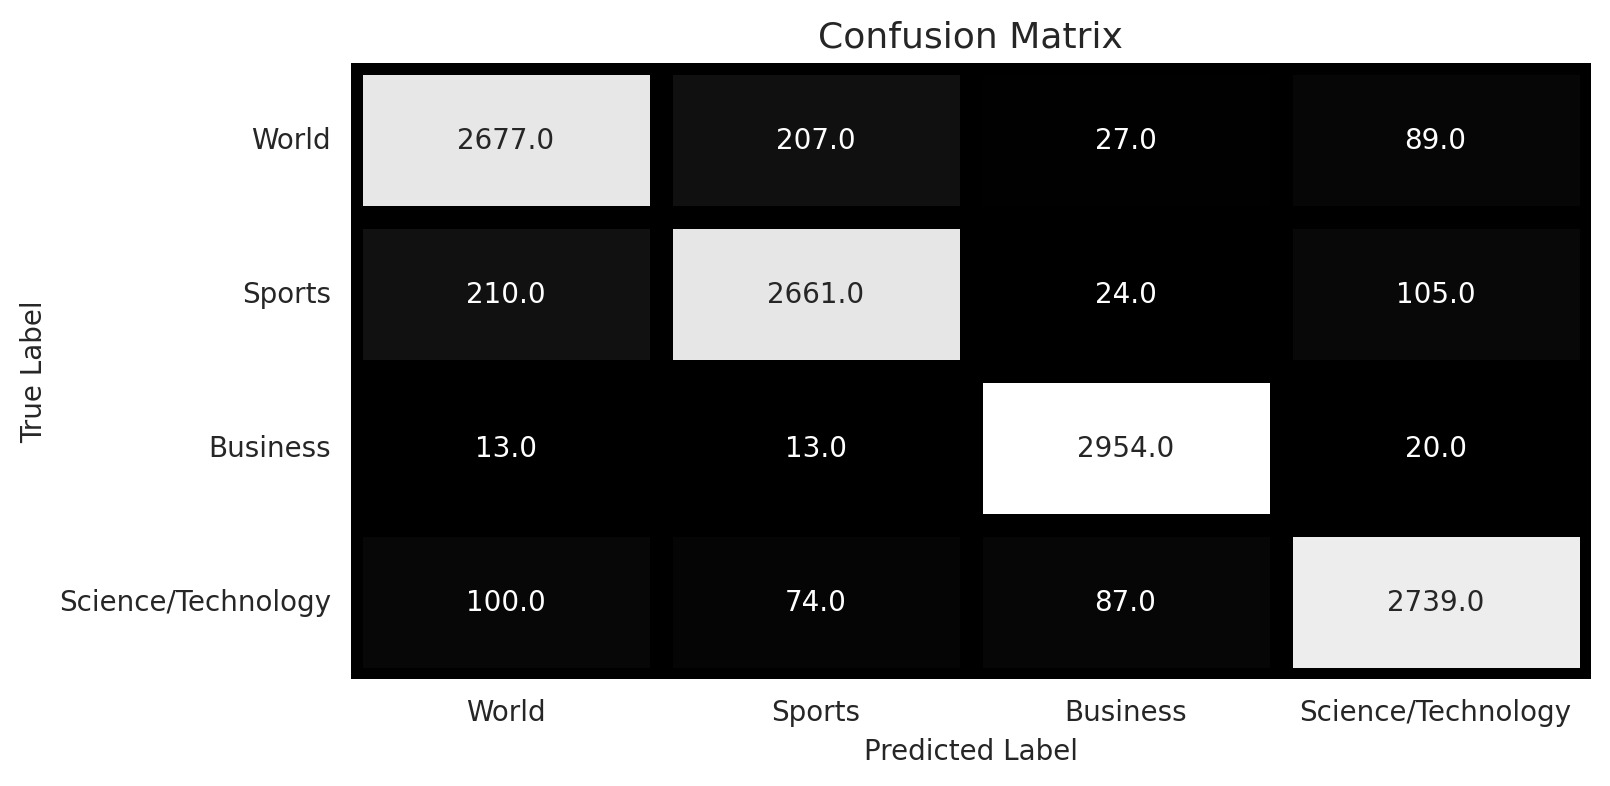

In [32]:
confusion_mtx = confusion_matrix(y_true, y_pred)

f,ax = plt.subplots(figsize = (8,4),dpi=200)
sns.heatmap(confusion_mtx,
            annot=True,
            linewidths=8.1,
            cmap="gist_yarg_r",
            linecolor="black",
            fmt=".1f",
            ax=ax,
            cbar=False,
            xticklabels=classes,
            yticklabels=classes)

plt.xlabel("Predicted Label", fontsize=10)
plt.ylabel("True Label", fontsize=10)

plt.title("Confusion Matrix", fontsize=13)

plt.show()

Check classification on random samples

In [33]:
sample_text = """
In the realm of technology, artificial intelligence (AI) stands as a revolutionary force, reshaping industries, augmenting human capabilities, and fueling innovation.
Through advanced algorithms and computational power, AI systems can analyze vast datasets, recognize patterns, and make autonomous decisions with unprecedented accuracy and efficiency.
From virtual assistants streamlining daily tasks to self-driving cars navigating complex environments, the potential applications of AI are vast and continually expanding.
While unlocking new possibilities, AI also raises ethical and societal considerations, prompting discussions on privacy, bias, and the future of work in an increasingly automated world.
"""

# Preprocess the text sample (replace this with your actual preprocessing steps)
processed_text =  text_preprocessor.preprocess(sample_text)
print(processed_text)

# Make predictions
predictions = model.predict(np.array([processed_text]))

predicted_probabilities = predictions[0]
# Create a list of tuples containing category index and probability
category_prob_tuples = [(i, prob) for i, prob in enumerate(predicted_probabilities)]
# Sort the list of tuples by probability in descending order
sorted_category_prob_tuples = sorted(category_prob_tuples, key=lambda x: x[1], reverse=True)
# Display the results
for i, (category_index, probability) in enumerate(sorted_category_prob_tuples):
    print(f"{i+1}. Category: {categories[category_index]}, Probability: {probability}")

realm technology artificial intelligence ai stand revolutionary force reshaping industry augmenting human capability fueling innovation advanced algorithm computational power ai system analyze vast datasets recognize pattern make autonomous decision unprecedented accuracy efficiency virtual assistant streamlining daily task self-driving car navigating complex environment potential application ai vast continually expanding unlocking new possibility ai also raise ethical societal consideration prompting discussion privacy bias future work increasingly automated world
1/1 [==============================] - 3s 3s/step
1. Category: Science/Technology, Probability: 0.9636746048927307
2. Category: Business, Probability: 0.0267433300614357
3. Category: World, Probability: 0.00951559841632843
4. Category: Sports, Probability: 6.639408093178645e-05
